In [ ]:
# ============================================================
# Trial16: Trial15 + (3) Tail-weighted loss (y_norm-based)
#
# 핵심 아이디어:
# - Trial15: (1) damage-proxy features + (2) tail-robust training
# - Trial16: (3) Tail-weighted loss 추가 -> 고장 근처(y_norm↓) 오차를 더 강하게 벌점
#
#   w = 1 + gamma * (1 - y_norm)^p   (tail일수록 w↑)
#   loss = mean( w * (pred_norm - y_norm)^2 )
#
# Keeps Trial9 evaluation pack: PH / α–λ / CRA / convergence + paper figures
# ============================================================

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial16"  

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5 
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512 
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # data loading
    num_workers: int = 0

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all

    # ===========================
    # Trial9-style Evaluation settings
    # ===========================
    alpha: float = 0.20
    ph_consecutive_m: int = 5
    rep_method: str = "mean" 
    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)
    lambda_to_plot: float = 0.6
    eps_rul: float = 1e-8

    # ===========================
    # Trial13 base features (min_vce only)
    # ===========================
    delta_steps: Tuple[int, ...] = (1, 5, 20, 50)
    ema_spans: Tuple[int, ...] = (10, 50) 
    roll_std_window: int = 10 
    add_window_stats: bool = True

    # ===========================
    # Trial15-1: Damage-proxy features (min_vce only)
    # ===========================
    add_damage_proxy: bool = True
    # vce_rel = vce - vce0
    # cum_pos = cumsum(max(delta_1,0))
    # cum_abs = cumsum(abs(delta_1))
    # cum_inc = cumsum(max(vce - vce0,0))
    # cum_acc = cumsum(abs(d(delta_1)))  (2차 변화량 누적)

    # ===========================
    # Temporal Pooling (Trial14 유지)
    # ===========================
    pooling: str = "mean_last_k"   # "last" | "mean_last_k" | "attn"
    pool_last_k: int = 10
    attn_dim: int = 128

    # ===========================
    # Trial15-2: Tail-robust training (shortcut 방지)
    # ===========================
    tail_robust_enable: bool = True
    tail_k_max: int = 10
    tail_apply_p: float = 1.0
    tail_mode: str = "mask"             # "mask" | "shuffle"
    tail_mask_value: float = 0.0

    # ===========================
    # Trial16: Tail-weighted loss (NEW)
    # ===========================
    tail_weight_enable: bool = True
    tail_weight_gamma: float = 5.0      # 추천 시작: 5
    tail_weight_p: float = 2.0          # 추천 시작: 2
    tail_weight_max: float = 20.0       # 안정화(상한)


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")
    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def delta_k(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out


def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    w = int(w)
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out


def _window_slope(seg: np.ndarray) -> float:
    L = len(seg)
    if L <= 1:
        return 0.0
    t = np.arange(L, dtype=np.float32)
    denom = float(np.var(t) + 1e-12)
    if denom <= 0:
        return 0.0
    return float(np.cov(t, seg, ddof=0)[0, 1] / denom)


def feature_names(cfg: Config) -> List[str]:
    names = ["min_vce"]
    for k in cfg.delta_steps:
        names.append(f"delta_{k}")
    for s in cfg.ema_spans:
        names.append(f"ema_{s}")
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        names.append(f"rollstd_{cfg.roll_std_window}")

    if cfg.add_damage_proxy:
        names += ["vce_rel", "cum_pos", "cum_abs", "cum_inc", "cum_acc"]

    if cfg.add_window_stats:
        names += ["win_mean", "win_std", "win_slope"]
    return names


def build_features_from_min_vce(vce: np.ndarray, cfg: Config) -> np.ndarray:
    """
    Return X(T,F) features derived ONLY from min_vce.
    (window_stats는 Dataset __getitem__에서 window segment 기준으로 append)
    """
    vce = vce.astype(np.float32)
    feats = [vce]  # min_vce

    # multi-scale deltas
    d1 = None
    for k in cfg.delta_steps:
        dk = delta_k(vce, int(k))
        feats.append(dk)
        if int(k) == 1:
            d1 = dk

    # EMA trends
    for s in cfg.ema_spans:
        feats.append(ema(vce, int(s)))

    # rolling std
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        feats.append(rolling_std(vce, int(cfg.roll_std_window)))

    # damage-proxy features
    if cfg.add_damage_proxy:
        v0 = float(vce[0])
        vce_rel = vce - v0

        if d1 is None:
            d1 = delta_k(vce, 1)

        cum_pos = np.cumsum(np.maximum(d1, 0.0)).astype(np.float32)
        cum_abs = np.cumsum(np.abs(d1)).astype(np.float32)
        cum_inc = np.cumsum(np.maximum(vce - v0, 0.0)).astype(np.float32)

        dd1 = np.zeros_like(d1, dtype=np.float32)
        dd1[1:] = d1[1:] - d1[:-1]
        cum_acc = np.cumsum(np.abs(dd1)).astype(np.float32)

        feats += [vce_rel.astype(np.float32), cum_pos, cum_abs, cum_inc, cum_acc]

    X = np.stack(feats, axis=1).astype(np.float32)  # (T, F_base(+damage))
    return X


# ============================================================
# 3) Tail-robust augmentation (TRAIN only)
# ============================================================
def apply_tail_robust(x_scaled: np.ndarray, cfg: Config, rng: np.random.RandomState) -> np.ndarray:
    """
    x_scaled: (L, F) already scaled (StandardScaler)
    Randomly perturb the last tail_k timesteps.
    """
    if (not cfg.tail_robust_enable) or cfg.tail_k_max <= 0:
        return x_scaled
    if rng.rand() > float(cfg.tail_apply_p):
        return x_scaled

    L, F = x_scaled.shape
    if L <= 1:
        return x_scaled

    k = int(rng.randint(0, int(cfg.tail_k_max) + 1))
    if k <= 0:
        return x_scaled

    x2 = x_scaled.copy()
    tail = slice(max(0, L - k), L)

    if cfg.tail_mode == "mask":
        x2[tail, :] = float(cfg.tail_mask_value)
    elif cfg.tail_mode == "shuffle":
        perm = rng.permutation(np.arange(tail.start, tail.stop))
        x2[tail, :] = x2[perm, :]
    else:
        x2[tail, :] = float(cfg.tail_mask_value)

    return x2


# ============================================================
# 3.5) Tail-weighted loss (NEW)
# ============================================================
def tail_weighted_mse(pred_norm: torch.Tensor, y_norm: torch.Tensor, cfg: Config) -> torch.Tensor:
    """
    pred_norm, y_norm: (B,1)
    w = 1 + gamma*(1-y)^p (clipped)
    loss = mean(w * (pred - y)^2)
    """
    if not cfg.tail_weight_enable:
        return torch.mean((pred_norm - y_norm) ** 2)

    y = y_norm.detach()
    one_minus = torch.clamp(1.0 - y, 0.0, 1.0)
    w = 1.0 + float(cfg.tail_weight_gamma) * torch.pow(one_minus, float(cfg.tail_weight_p))
    if cfg.tail_weight_max is not None and float(cfg.tail_weight_max) > 0:
        w = torch.clamp(w, max=float(cfg.tail_weight_max))

    return torch.mean(w * (pred_norm - y_norm) ** 2)


# ============================================================
# 4) Dataset
# ============================================================
class WindowedRULDatasetNormMinVCE_Trial16(Dataset):
    """
    Returns:
      x: (seq_len, F)
      y_norm: (1,)
      name, start_idx, y_cycles, rul0
    """
    def __init__(
        self,
        file_list: List[Path],
        cfg: Config,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
        is_train: bool = False,
    ):
        self.file_list = file_list
        self.cfg = cfg
        self.seq_len = cfg.seq_len
        self.stride = cfg.stride
        self.pred_horizon = cfg.pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()
        self.is_train = bool(is_train)

        # deterministic rng per dataset instance (for tail augment)
        self._rng = np.random.RandomState(1234 if self.is_train else 4321)

        # store: (name, Xbase(T,Fbase), vce(T,), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            Xbase = build_features_from_min_vce(vce, cfg).astype(np.float32)
            self.series.append((fp.name, Xbase, vce.astype(np.float32), rul.astype(np.float32), rul0))

        # Fit scaler (train only)
        if fit_scaler:
            if not cfg.add_window_stats:
                all_x = np.concatenate([Xbase for _, Xbase, _, _, _ in self.series], axis=0)
                self.scaler_x.fit(all_x)
            else:
                rng = np.random.RandomState(0)
                rows = []
                max_windows_for_scaler = 5000
                for (_name, Xbase, vce_raw, _rul, _rul0) in self.series:
                    T = Xbase.shape[0]
                    last_start = T - (self.seq_len + self.pred_horizon)
                    if last_start < 0:
                        continue
                    starts = list(range(0, last_start + 1, self.stride))
                    if len(starts) == 0:
                        continue
                    if len(starts) > 200:
                        starts = rng.choice(starts, size=200, replace=False).tolist()
                    for s in starts:
                        xw = Xbase[s:s + self.seq_len, :]  # (L,Fbase)
                        seg = vce_raw[s:s + self.seq_len]
                        wmean = float(np.mean(seg))
                        wstd = float(np.std(seg, ddof=0))
                        slope = _window_slope(seg)
                        stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
                        stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
                        xfull = np.concatenate([xw, stats_rep], axis=1)  # (L,F)
                        rows.append(xfull)
                        if len(rows) >= max_windows_for_scaler:
                            break
                    if len(rows) >= max_windows_for_scaler:
                        break
                if len(rows) == 0:
                    raise ValueError("Scaler fitting failed: no windows sampled. Check seq_len/stride.")
                fit_mat = np.concatenate(rows, axis=0)
                self.scaler_x.fit(fit_mat)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, Xbase, _vce, _rul, _rul0) in enumerate(self.series):
            T = Xbase.shape[0]
            last_start = T - (self.seq_len + self.pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, self.stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, Xbase, vce_raw, rul, rul0 = self.series[fi]

        x = Xbase[s:s + self.seq_len, :]  # (L,Fbase)

        if self.cfg.add_window_stats:
            seg = vce_raw[s:s + self.seq_len]
            wmean = float(np.mean(seg))
            wstd = float(np.std(seg, ddof=0))
            slope = _window_slope(seg)
            stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
            stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
            x = np.concatenate([x, stats_rep], axis=1).astype(np.float32)  # (L,F)

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        # scale first
        x = self.scaler_x.transform(x).astype(np.float32)

        # TRAIN only: tail-robust
        if self.is_train and self.cfg.tail_robust_enable:
            x = apply_tail_robust(x, self.cfg, self._rng).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 5) Model (Temporal pooling 유지)
# ============================================================
class TemporalPool(nn.Module):
    def __init__(self, mode: str, hidden_size: int, last_k: int = 10, attn_dim: int = 128):
        super().__init__()
        self.mode = str(mode)
        self.last_k = int(last_k)
        self.attn_dim = int(attn_dim)

        if self.mode == "attn":
            self.proj = nn.Sequential(
                nn.Linear(hidden_size, self.attn_dim),
                nn.Tanh(),
                nn.Linear(self.attn_dim, 1),
            )

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        """
        h: (B, L, H)
        returns pooled: (B, H)
        """
        if self.mode == "last":
            return h[:, -1, :]

        if self.mode == "mean_last_k":
            L = h.size(1)
            k = min(self.last_k, L)
            return torch.mean(h[:, -k:, :], dim=1)

        if self.mode == "attn":
            scores = self.proj(h)              # (B, L, 1)
            w = torch.softmax(scores, dim=1)   # (B, L, 1)
            return torch.sum(w * h, dim=1)     # (B, H)

        return h[:, -1, :]


class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float,
                 pooling: str, pool_last_k: int, attn_dim: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.pool = TemporalPool(pooling, hidden_size, last_k=pool_last_k, attn_dim=attn_dim)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        h, _ = self.lstm(x)     # (B, L, H)
        z = self.pool(h)        # (B, H)
        return self.head(z)     # (B, 1) norm-scale


# ============================================================
# 6) Basic Eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 7) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 8) Prognostics metrics (same as Trial9)
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:

    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:

    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 9) Plotters (same as Trial14)
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")
        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--", label=f"+{alpha:.2f} alpha–lambda zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--", label=f"-{alpha:.2f} alpha–lambda zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 10) One seed run
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    # split
    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    # save split lists
    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    # datasets (fit scaler on train only)
    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNormMinVCE_Trial16(
        splits["train"], cfg, scaler_x=scaler_x, fit_scaler=True, is_train=True
    )
    val_ds = WindowedRULDatasetNormMinVCE_Trial16(
        splits["val"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False, is_train=False
    )
    test_ds = WindowedRULDatasetNormMinVCE_Trial16(
        splits["test"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False, is_train=False
    )

    feat_list = feature_names(cfg)
    pd.DataFrame({
        "feature": feat_list,
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    # model
    input_size = len(feat_list)
    model = LSTMRegressor(
        input_size=input_size,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        pooling=cfg.pooling,
        pool_last_k=cfg.pool_last_k,
        attn_dim=cfg.attn_dim,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_by_val_norm = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_norm.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, y_norm, *_ in train_loader:
            x = x.to(device)
            y_norm = y_norm.to(device)

            optimizer.zero_grad()
            pred_norm = model(x)

            # ✅ Trial16 change: tail-weighted loss
            loss = tail_weighted_mse(pred_norm, y_norm, cfg)

            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            losses.append(loss.item())

        train_loss = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
        })

        if val_metrics["rmse_norm"] < best_by_val_norm:
            best_by_val_norm = val_metrics["rmse_norm"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_loss={train_loss:.6f} | "
                f"val_rmse_norm={val_metrics['rmse_norm']:.6f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_norm={best_by_val_norm:.6f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name}",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,

            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],

            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],

            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],

            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_norm": best_by_val_norm,

            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,

            "feature_dim": input_size,
            "features": ",".join(feature_names(cfg)),

            # Trial15 extras
            "pooling": cfg.pooling,
            "pool_last_k": cfg.pool_last_k,
            "tail_robust_enable": int(cfg.tail_robust_enable),
            "tail_k_max": cfg.tail_k_max,
            "tail_apply_p": cfg.tail_apply_p,
            "tail_mode": cfg.tail_mode,

            # Trial16 extras
            "tail_weight_enable": int(cfg.tail_weight_enable),
            "tail_weight_gamma": cfg.tail_weight_gamma,
            "tail_weight_p": cfg.tail_weight_p,
            "tail_weight_max": cfg.tail_weight_max,
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(
            f"[SEED {seed}] {tag}: TEST mae_cycles={te['mae_cycles']:.3f} | "
            f"rmse_cycles={te['rmse_cycles']:.3f} | rmse_norm={te['rmse_norm']:.6f}"
        )
        return ms

    ms_best = export_ckpt("best_by_val_norm", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 11) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial16_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial16 folder:")
    print(" - per seed results: Trial16/seed_<seed>/...")
    print(" - figures (paper-style): seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle sequence mean CSV: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics CSV: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 12) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial16",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),
        lambda_to_plot=0.6,

        # base features
        delta_steps=(1, 5, 20, 50),
        ema_spans=(10, 50),
        roll_std_window=10,
        add_window_stats=True,

        # Trial15-1
        add_damage_proxy=True,

        # pooling (keep Trial14 default)
        pooling="mean_last_k",
        pool_last_k=10,
        attn_dim=128,

        # Trial15-2
        tail_robust_enable=True,
        tail_k_max=10,
        tail_apply_p=1.0,
        tail_mode="mask",
        tail_mask_value=0.0,

        # Trial16 (NEW)
        tail_weight_enable=True,
        tail_weight_gamma=5.0,
        tail_weight_p=2.0,
        tail_weight_max=20.0,
    )

    run_trial16_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial16\seed_9819123
[SEED 9819123] [001/300] train_loss=0.012653 | val_rmse_norm=0.056517 | val_mae_cycles=492.268 | best_val_rmse_norm=0.056517
[SEED 9819123] [010/300] train_loss=0.000871 | val_rmse_norm=0.048573 | val_mae_cycles=547.900 | best_val_rmse_norm=0.037098
[SEED 9819123] [020/300] train_loss=0.000527 | val_rmse_norm=0.050891 | val_mae_cycles=599.562 | best_val_rmse_norm=0.037098
[SEED 9819123] [030/300] train_loss=0.000331 | val_rmse_norm=0.046933 | val_mae_cycles=520.247 | best_val_rmse_norm=0.037098
[SEED 9819123] Early stopping at epoch 32.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 9819123] best_by_val_norm: TEST mae_cycles=249.853 | rmse_cycles=342.339 | rmse_norm=0.026770


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 9819123] last_epoch: TEST mae_cycles=247.846 | rmse_cycles=359.836 | rmse_norm=0.032369

[SEED 111] device=cuda
[SEED 111] out=./Trial16\seed_111
[SEED 111] [001/300] train_loss=0.012995 | val_rmse_norm=0.079930 | val_mae_cycles=1825.056 | best_val_rmse_norm=0.079930
[SEED 111] [010/300] train_loss=0.000848 | val_rmse_norm=0.058286 | val_mae_cycles=1260.192 | best_val_rmse_norm=0.045446
[SEED 111] [020/300] train_loss=0.001044 | val_rmse_norm=0.058236 | val_mae_cycles=1297.952 | best_val_rmse_norm=0.045446
[SEED 111] [030/300] train_loss=0.000503 | val_rmse_norm=0.061000 | val_mae_cycles=1208.225 | best_val_rmse_norm=0.045446
[SEED 111] Early stopping at epoch 37.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 111] best_by_val_norm: TEST mae_cycles=355.973 | rmse_cycles=543.241 | rmse_norm=0.032696


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 111] last_epoch: TEST mae_cycles=519.697 | rmse_cycles=940.499 | rmse_norm=0.045939

[SEED 222] device=cuda
[SEED 222] out=./Trial16\seed_222
[SEED 222] [001/300] train_loss=0.010301 | val_rmse_norm=0.033235 | val_mae_cycles=347.663 | best_val_rmse_norm=0.033235
[SEED 222] [010/300] train_loss=0.000872 | val_rmse_norm=0.029040 | val_mae_cycles=301.285 | best_val_rmse_norm=0.027871
[SEED 222] [020/300] train_loss=0.000412 | val_rmse_norm=0.030763 | val_mae_cycles=331.710 | best_val_rmse_norm=0.027871
[SEED 222] [030/300] train_loss=0.000320 | val_rmse_norm=0.036835 | val_mae_cycles=399.311 | best_val_rmse_norm=0.027871
[SEED 222] Early stopping at epoch 36.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 222] best_by_val_norm: TEST mae_cycles=376.225 | rmse_cycles=565.104 | rmse_norm=0.025971


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 222] last_epoch: TEST mae_cycles=468.531 | rmse_cycles=843.380 | rmse_norm=0.032845

[SEED 333] device=cuda
[SEED 333] out=./Trial16\seed_333
[SEED 333] [001/300] train_loss=0.014326 | val_rmse_norm=0.045298 | val_mae_cycles=442.634 | best_val_rmse_norm=0.045298
[SEED 333] [010/300] train_loss=0.000986 | val_rmse_norm=0.043422 | val_mae_cycles=411.594 | best_val_rmse_norm=0.037635
[SEED 333] [020/300] train_loss=0.000460 | val_rmse_norm=0.048589 | val_mae_cycles=506.797 | best_val_rmse_norm=0.037635
[SEED 333] [030/300] train_loss=0.000581 | val_rmse_norm=0.047915 | val_mae_cycles=464.439 | best_val_rmse_norm=0.037635
[SEED 333] Early stopping at epoch 32.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 333] best_by_val_norm: TEST mae_cycles=119.948 | rmse_cycles=157.840 | rmse_norm=0.029590


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 333] last_epoch: TEST mae_cycles=150.237 | rmse_cycles=213.435 | rmse_norm=0.033718

[SEED 444] device=cuda
[SEED 444] out=./Trial16\seed_444
[SEED 444] [001/300] train_loss=0.010731 | val_rmse_norm=0.053908 | val_mae_cycles=840.823 | best_val_rmse_norm=0.053908
[SEED 444] [010/300] train_loss=0.000787 | val_rmse_norm=0.044716 | val_mae_cycles=719.641 | best_val_rmse_norm=0.031433
[SEED 444] [020/300] train_loss=0.000416 | val_rmse_norm=0.044502 | val_mae_cycles=641.932 | best_val_rmse_norm=0.031433
[SEED 444] [030/300] train_loss=0.000310 | val_rmse_norm=0.046460 | val_mae_cycles=667.217 | best_val_rmse_norm=0.031433
[SEED 444] Early stopping at epoch 34.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 444] best_by_val_norm: TEST mae_cycles=381.546 | rmse_cycles=581.165 | rmse_norm=0.031754


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_81736\2260367434.py:1045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 444] last_epoch: TEST mae_cycles=471.214 | rmse_cycles=663.660 | rmse_norm=0.038211
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=1, best wins=4, ties=0 | mean(last-best)=74.796040, std(last-best)=57.123585
- test_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=166.224092, std(last-best)=146.493403
- test_mae_norm: last wins=0, best wins=5, ties=0 | mean(last-best)=0.003811, std(last-best)=0.001595
- test_rmse_norm: last wins=0, best wins=5, ties=0 | mean(last-best)=0.007260, std(last-best)=0.003135

=== MEAN ± STD across seeds (TEST) ===
                 test_mae_cycles             test_rmse_cycles              \
                            mean         std             mean         std   
checkpoint                                                                  
best_by_val_norm      296.708789  112.330235       437.937941  183.961977   
last_epoch            371.504829  162.455862       604.162033  310.745625   

               

In [2]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial16 paths
# ============================
TRIAL_DIR = "./Trial16"
SUMMARY_CSV = os.path.join(TRIAL_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule:
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # 1) VAL 기준 best (권장)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (참고)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")

    # Trial 계열에서 norm 지표도 같이 확인
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial16) ================")
    print("[SELECTED BY VAL]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")

    print("\n[SELECTED BY TEST] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL_DIR, "BEST_MODEL_BY_VAL.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial16) - Selected by VAL\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")

    print(f"Saved -> {out_txt}")

    # (선택) Trial16이 이미 만들어둔 win-rate 파일도 안내
    wr_csv = os.path.join(TRIAL_DIR, "win_rate_summary.csv")
    wr_txt = os.path.join(TRIAL_DIR, "win_rate_summary.txt")
    if os.path.exists(wr_csv):
        print(f"(Info) Found -> {wr_csv}")
    if os.path.exists(wr_txt):
        print(f"(Info) Found -> {wr_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial16) ================
[SELECTED BY VAL]  (recommended for model selection)
  Seed             : 222
  Checkpoint       : best_by_val_norm
  VAL  RMSE (cyc)   : 460.444
  VAL  MAE  (cyc)   : 287.159
  VAL  RMSE (norm)  : 0.027871
  VAL  MAE  (norm)  : 0.021838
  TEST RMSE (cyc)   : 565.104
  TEST MAE  (cyc)   : 376.225
  TEST RMSE (norm)  : 0.025971
  TEST MAE  (norm)  : 0.019829

[SELECTED BY TEST] (for reporting only; not for tuning)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  TEST RMSE (cyc)   : 157.840
  TEST MAE  (cyc)   : 119.948
  TEST RMSE (norm)  : 0.029590
  TEST MAE  (norm)  : 0.022665
  VAL  RMSE (cyc)   : 612.667
  VAL  MAE  (cyc)   : 479.469
  VAL  RMSE (norm)  : 0.037635
  VAL  MAE  (norm)  : 0.030291

---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------
- val_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=340.634458
- test_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(la

In [ ]:
import os
import re
import pandas as pd
import numpy as np

# =========================
# USER CONFIG (Trial16)
# =========================
TRIAL_DIR = r"./Trial16"                 # ✅ Trial16 루트
SPLITS = ["train", "val", "test"]        # 평가할 split

# (선택) 후반 λ를 더 중요하게 보고 싶으면 가중치 사용
# 예: {"0.20":1, "0.40":1, "0.60":2, "0.80":3}
LAMBDA_WEIGHTS = None

# summary 파일 (Trial16 seed sweep 결과)
SUMMARY_CSV = os.path.join(TRIAL_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def _list_dir(path: str):
    if not os.path.isdir(path):
        return []
    return sorted([p for p in os.listdir(path)])


def discover_lambdas_from_columns(dfm: pd.DataFrame) -> list:
    """
    compute_metrics_for_one_file()가 생성하는 컬럼:
      - alpha_lambda_ok_{lam:.2f}
      - t_lambda_{lam:.2f}
    여기서 lam 문자열("0.20")을 자동 추출.
    """
    lam = []
    pat = re.compile(r"^alpha_lambda_ok_(\d+\.\d+)$")
    for c in dfm.columns:
        m = pat.match(c)
        if m:
            lam.append(m.group(1))
    lam = sorted(set(lam), key=lambda s: float(s))
    return lam


def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs: list, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv (per-file summary)
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}

    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col in dfm.columns:
            rates[f"rate_{ls}"] = float(dfm[col].mean())  # 0/1 평균 = 성공률
        else:
            rates[f"rate_{ls}"] = np.nan

    # overall score
    if weights is None:
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        num = 0.0
        den = 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule:
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def run_alpha_lambda_for_one_selection(selection_name: str, seed: int, ckpt: str) -> None:
    """
    selection_name: "selected_by_val" or "selected_by_test"
    seed, ckpt: chosen from summary_across_seeds.csv
    """
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{seed}", ckpt)
    if not os.path.isdir(seed_dir):
        seed_root = os.path.join(TRIAL_DIR, f"seed_{seed}")
        msg = [
            f"[{selection_name}] Not found: {seed_dir}",
            f"Available under {TRIAL_DIR}: {_list_dir(TRIAL_DIR)}",
            f"Available ckpts under {seed_root}: {_list_dir(seed_root)}",
        ]
        raise FileNotFoundError("\n".join(msg))

    # ✅ 저장은 Trial16 루트 아래로 (한 군데에 모으기)
    out_dir = os.path.join(TRIAL_DIR, "alpha_lambda_eval", selection_name, f"seed_{seed}", ckpt)
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []

    for split in SPLITS:
        mpath = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[{selection_name}] [SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)
        _require_cols(dfm, ["file"])

        lam_strs = discover_lambdas_from_columns(dfm)
        if not lam_strs:
            print(f"[{selection_name}] [WARN] No alpha_lambda_ok_* columns in: {mpath}")
            continue

        rates = compute_alpha_lambda_rates(dfm, lam_strs, weights=LAMBDA_WEIGHTS)

        row = {
            "trial": "Trial16",
            "selection": selection_name,
            "seed": int(seed),
            "checkpoint": str(ckpt),
            "split": split,
            "n_files": int(len(dfm)),
            "lambdas_found": ",".join(lam_strs),
            **rates,
        }
        summary_rows.append(row)

        # per-file export
        keep_cols = ["file"]
        for ls in lam_strs:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)

        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", ckpt)
        sub.insert(0, "seed", seed)
        sub.insert(0, "selection", selection_name)
        sub.insert(0, "trial", "Trial16")
        per_file_rows.append(sub)

        # console
        msg_parts = []
        for ls in lam_strs:
            v = row.get(f"rate_{ls}", np.nan)
            if np.isfinite(v):
                msg_parts.append(f"λ={ls}:{v:.3f}")
        msg = ", ".join(msg_parts) if msg_parts else "no lambda columns found"

        tail = ""
        if "rate_weighted_all" in row and np.isfinite(row["rate_weighted_all"]):
            tail = f" | weighted_all={row['rate_weighted_all']:.3f}"
        elif "rate_mean_all" in row and np.isfinite(row["rate_mean_all"]):
            tail = f" | mean_all={row['rate_mean_all']:.3f}"

        print(f"[{selection_name}] [OK] {split}: {msg}{tail}")

    # save
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, f"alpha_lambda_summary__{selection_name}__seed{seed}_{ckpt}.csv")
    df_summary.to_csv(out_summary, index=False)

    out_pf = None
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, f"alpha_lambda_per_file__{selection_name}__seed{seed}_{ckpt}.csv")
        df_pf.to_csv(out_pf, index=False)

    print("\n==================== DONE ====================")
    print(f"Trial: Trial16 | selection={selection_name} | seed={seed} | ckpt={ckpt}")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")

    if not df_summary.empty:
        base = ["split", "n_files", "lambdas_found"]
        extra = [c for c in df_summary.columns if c.startswith("rate_")]
        show_cols = [c for c in (base + extra) if c in df_summary.columns]
        print("\n--- Quick view ---")
        print(df_summary[show_cols].to_string(index=False))


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(
            f"Not found: {SUMMARY_CSV}\n"
            f"먼저 Trial16 학습 스크립트(run_trial16_seed_sweep)를 실행해 summary_across_seeds.csv를 생성하세요."
        )

    df = pd.read_csv(SUMMARY_CSV)

    # ✅ 이미지에서 네가 본 것과 같은 로직:
    # - best by val: val_rmse_cycles -> val_mae_cycles
    # - best by test: test_rmse_cycles -> test_mae_cycles
    best_val = pick_best_row(df, metric_prefix="val")
    best_test = pick_best_row(df, metric_prefix="test")

    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    print("\n================ SELECTION (from summary_across_seeds.csv) ================")
    print(f"[BEST BY VAL]  seed={best_val_seed}, ckpt={best_val_ckpt}, "
          f"val_rmse_cycles={best_val['val_rmse_cycles']:.3f}, val_mae_cycles={best_val['val_mae_cycles']:.3f}")
    print(f"[BEST BY TEST] seed={best_test_seed}, ckpt={best_test_ckpt}, "
          f"test_rmse_cycles={best_test['test_rmse_cycles']:.3f}, test_mae_cycles={best_test['test_mae_cycles']:.3f}")
    print("============================================================================\n")

    run_alpha_lambda_for_one_selection("selected_by_val", best_val_seed, best_val_ckpt)
    print()
    run_alpha_lambda_for_one_selection("selected_by_test", best_test_seed, best_test_ckpt)

    print("\nALL DONE.")
    print("Check outputs under:")
    print(os.path.join(TRIAL_DIR, "alpha_lambda_eval"))


if __name__ == "__main__":
    main()



================ SELECTION (from summary_across_seeds.csv) ================
[BEST BY VAL]  seed=222, ckpt=best_by_val_norm, val_rmse_cycles=460.444, val_mae_cycles=287.159
[BEST BY TEST] seed=333, ckpt=best_by_val_norm, test_rmse_cycles=157.840, test_mae_cycles=119.948

[selected_by_val] [OK] train: λ=0.20:1.000, λ=0.40:1.000, λ=0.60:1.000, λ=0.80:0.900 | mean_all=0.975
[selected_by_val] [OK] val: λ=0.20:1.000, λ=0.40:1.000, λ=0.60:1.000, λ=0.80:0.700 | mean_all=0.925
[selected_by_val] [OK] test: λ=0.20:1.000, λ=0.40:1.000, λ=0.60:1.000, λ=0.80:0.800 | mean_all=0.950

==================== DONE ====================
Trial: Trial16 | selection=selected_by_val | seed=222 | ckpt=best_by_val_norm
Saved:
 - ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\alpha_lambda_summary__selected_by_val__seed222_best_by_val_norm.csv
 - ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\alpha_lambda_per_file__selected_by_val__seed222_best_by_val_norm.csv

--- Quic


=== Using selections from Trial16 summary ===
[BEST BY VAL]  seed=222, ckpt=best_by_val_norm
[BEST BY TEST] seed=333, ckpt=best_by_val_norm


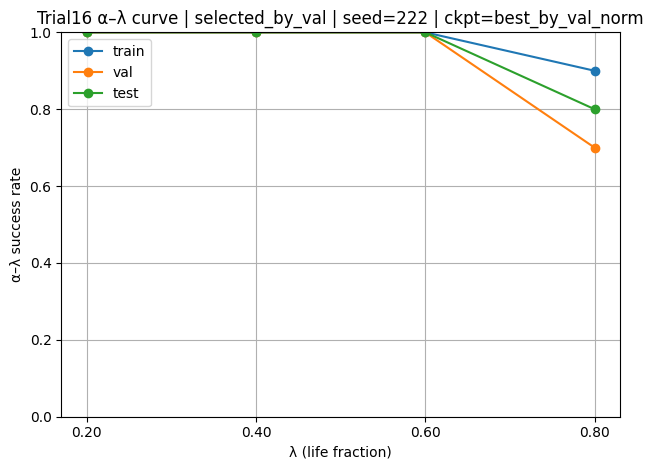

[SAVE] ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\alpha_lambda_curve__selected_by_val__seed222_best_by_val_norm.png


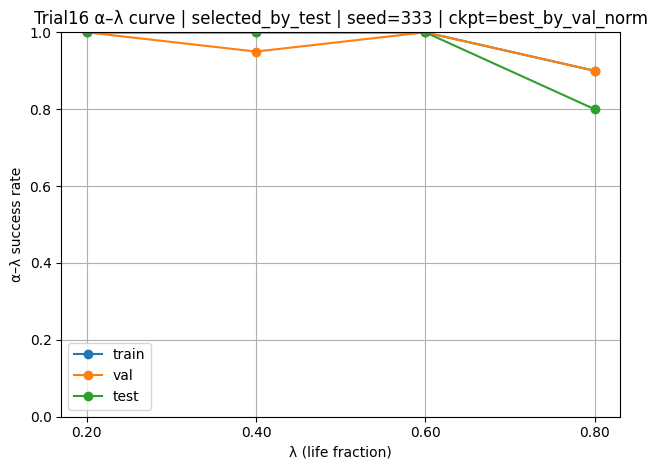

[SAVE] ./Trial16\alpha_lambda_eval\selected_by_test\seed_333\best_by_val_norm\alpha_lambda_curve__selected_by_test__seed333_best_by_val_norm.png


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# USER CONFIG
# =========================
TRIAL_DIR = r"./Trial16"
SUMMARY_ACROSS = os.path.join(TRIAL_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"

# 기본 λ (파일에 없으면 이걸로 시도)
DEFAULT_LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]
SPLITS_ORDER = ["train", "val", "test"]

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule:
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def infer_lam_strs_from_summary(df_sum: pd.DataFrame):
    # rate_0.20, rate_0.40 ... 컬럼에서 자동 추출
    lam = []
    for c in df_sum.columns:
        if c.startswith("rate_") and c not in ("rate_mean_all", "rate_weighted_all"):
            lam.append(c.replace("rate_", ""))
    lam = sorted(set(lam), key=lambda s: float(s))
    if lam:
        return lam
    return DEFAULT_LAM_STRS


def plot_one(summary_csv: str, out_png: str, title: str):
    if not os.path.exists(summary_csv):
        raise FileNotFoundError(
            f"Not found: {summary_csv}\n"
            f"먼저 alpha-lambda 요약 스크립트를 실행해 summary CSV를 생성하세요."
        )

    df = pd.read_csv(summary_csv)

    lam_strs = infer_lam_strs_from_summary(df)
    lam = [float(x) for x in lam_strs]

    plt.figure()
    for split in SPLITS_ORDER:
        sub = df[df["split"] == split]
        if sub.empty:
            continue
        row = sub.iloc[0]
        rates = [float(row.get(f"rate_{ls}", np.nan)) for ls in lam_strs]
        plt.plot(lam, rates, marker="o", label=split)

    plt.xticks(lam, [f"{x:.2f}" for x in lam])
    plt.ylim(0, 1.0)
    plt.xlabel("λ (life fraction)")
    plt.ylabel("α–λ success rate")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()

    print(f"[SAVE] {out_png}")


def main():
    if not os.path.exists(SUMMARY_ACROSS):
        raise FileNotFoundError(f"Not found: {SUMMARY_ACROSS}")

    df = pd.read_csv(SUMMARY_ACROSS)

    # best by val / best by test 선택
    best_val = pick_best_row(df, metric_prefix="val")
    best_test = pick_best_row(df, metric_prefix="test")

    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # 내가 이전에 준 alpha-lambda 요약 스크립트 저장 규칙에 맞춘 입력 경로
    sum_val = os.path.join(
        TRIAL_DIR, "alpha_lambda_eval", "selected_by_val",
        f"seed_{best_val_seed}", best_val_ckpt,
        f"alpha_lambda_summary__selected_by_val__seed{best_val_seed}_{best_val_ckpt}.csv"
    )
    sum_test = os.path.join(
        TRIAL_DIR, "alpha_lambda_eval", "selected_by_test",
        f"seed_{best_test_seed}", best_test_ckpt,
        f"alpha_lambda_summary__selected_by_test__seed{best_test_seed}_{best_test_ckpt}.csv"
    )

    out_val = os.path.join(
        TRIAL_DIR, "alpha_lambda_eval", "selected_by_val",
        f"seed_{best_val_seed}", best_val_ckpt,
        f"alpha_lambda_curve__selected_by_val__seed{best_val_seed}_{best_val_ckpt}.png"
    )
    out_test = os.path.join(
        TRIAL_DIR, "alpha_lambda_eval", "selected_by_test",
        f"seed_{best_test_seed}", best_test_ckpt,
        f"alpha_lambda_curve__selected_by_test__seed{best_test_seed}_{best_test_ckpt}.png"
    )

    print("\n=== Using selections from Trial16 summary ===")
    print(f"[BEST BY VAL]  seed={best_val_seed}, ckpt={best_val_ckpt}")
    print(f"[BEST BY TEST] seed={best_test_seed}, ckpt={best_test_ckpt}")

    plot_one(
        summary_csv=sum_val,
        out_png=out_val,
        title=f"Trial16 α–λ curve | selected_by_val | seed={best_val_seed} | ckpt={best_val_ckpt}"
    )
    plot_one(
        summary_csv=sum_test,
        out_png=out_test,
        title=f"Trial16 α–λ curve | selected_by_test | seed={best_test_seed} | ckpt={best_test_ckpt}"
    )


if __name__ == "__main__":
    main()


In [5]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial16)
# =========================
TRIAL_DIR = r"./Trial16"
SPLITS = ["train", "val", "test"]

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60
MAX_FILES = None  # None=all, or e.g., 10

SUMMARY_ACROSS = os.path.join(TRIAL_DIR, "summary_across_seeds.csv")

# =========================
# Helpers
# =========================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule:
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def load_cycle_seq_and_metrics(seed_ckpt_dir: str, split: str):
    """
    Trial16 export_ckpt()가 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    위치:
      <TRIAL_DIR>/seed_<seed>/<ckpt>/
    """
    seq_csv = os.path.join(seed_ckpt_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_ckpt_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met


def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df


# =========================
# Plotters
# =========================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


# =========================
# Main runner
# =========================
def run_for_one_split(seed_ckpt_dir: str, out_root: str, split: str, seed: int, ckpt: str, title_prefix: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_ckpt_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(out_root, split)
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])

        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{title_prefix}] [{split}] DONE -> {out_dir}")


def run_selection(selection_name: str, seed: int, ckpt: str):
    seed_ckpt_dir = os.path.join(TRIAL_DIR, f"seed_{seed}", ckpt)
    if not os.path.isdir(seed_ckpt_dir):
        raise FileNotFoundError(f"Not found: {seed_ckpt_dir}")

    # ✅ 결과 저장: Trial16 루트 아래 selection별로 분리
    out_root = os.path.join(
        TRIAL_DIR, "alpha_lambda_eval", selection_name,
        f"seed_{seed}", ckpt,
        "paper_figures_bookstyle"
    )
    os.makedirs(out_root, exist_ok=True)

    title_prefix = f"Trial16 | {selection_name} | SEED {seed} | {ckpt.upper()}"

    for split in SPLITS:
        run_for_one_split(seed_ckpt_dir, out_root, split, seed, ckpt, title_prefix)

    print(f"\n[{selection_name}] ALL DONE. Saved under:\n  {out_root}\n")


def main():
    if not os.path.exists(SUMMARY_ACROSS):
        raise FileNotFoundError(f"Not found: {SUMMARY_ACROSS}")

    df = pd.read_csv(SUMMARY_ACROSS)

    best_val = pick_best_row(df, metric_prefix="val")
    best_test = pick_best_row(df, metric_prefix="test")

    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    print("\n=== Using selections from Trial16 summary ===")
    print(f"[BEST BY VAL]  seed={best_val_seed}, ckpt={best_val_ckpt}")
    print(f"[BEST BY TEST] seed={best_test_seed}, ckpt={best_test_ckpt}")

    run_selection("selected_by_val", best_val_seed, best_val_ckpt)
    run_selection("selected_by_test", best_test_seed, best_test_ckpt)


if __name__ == "__main__":
    main()



=== Using selections from Trial16 summary ===
[BEST BY VAL]  seed=222, ckpt=best_by_val_norm
[BEST BY TEST] seed=333, ckpt=best_by_val_norm
[Trial16 | selected_by_val | SEED 222 | BEST_BY_VAL_NORM] [train] DONE -> ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\paper_figures_bookstyle\train
[Trial16 | selected_by_val | SEED 222 | BEST_BY_VAL_NORM] [val] DONE -> ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\paper_figures_bookstyle\val
[Trial16 | selected_by_val | SEED 222 | BEST_BY_VAL_NORM] [test] DONE -> ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\paper_figures_bookstyle\test

[selected_by_val] ALL DONE. Saved under:
  ./Trial16\alpha_lambda_eval\selected_by_val\seed_222\best_by_val_norm\paper_figures_bookstyle

[Trial16 | selected_by_test | SEED 333 | BEST_BY_VAL_NORM] [train] DONE -> ./Trial16\alpha_lambda_eval\selected_by_test\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[Trial16 | selected_by_test 